# Импорт

In [9]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [10]:
torch.cuda.set_device(0)
device = torch.device("cuda:0")

# PINN модель

In [11]:
class PINN_Model(nn.Module):
  def __init__(self,
               hidden_size=20):
    super().__init__()
    self.layers_stack = nn.Sequential(
        nn.Linear(1, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, 1),
        nn.Tanh(),
    )

  def forward(self, x):
    return self.layers_stack(x)

# PDE

In [12]:
def pde(out, t, nu=2):
    omega = 2 * torch.pi * nu
    dxdt = torch.autograd.grad(out, t, torch.ones_like(t), create_graph=True, retain_graph=True)[0]
    d2xdt2 = torch.autograd.grad(dxdt, t, torch.ones_like(t), create_graph=True, retain_graph=True)[0]
    
    # Уравнение гармонического осциллятора с вынуждающей силой
    forcing_term = 1*torch.cos(omega * t)  # Вынуждающая сила
    f = d2xdt2 + (omega ** 2) * out - forcing_term  # Уравнение с вынуждающей силой
    return f

# Параметры задачи

In [13]:
nu=2
omega = 2 * torch.pi * nu
x0_true=torch.tensor([1], dtype=float).float().to(device)
dx0dt_true=torch.tensor([0], dtype=float).float().to(device)

# Обучение

In [17]:
def pdeBC(t):
    out = model(t).to(device)
    f1 = pde(out, t)

    inlet_mask = (t[:, 0] == 0)
    t0 = t[inlet_mask]
    x0 = model(t0).to(device)
    dx0dt = torch.autograd.grad(x0, t0, torch.ones_like(t0), create_graph=True, \
                        retain_graph=True)[0]

    loss_bc = metric_data(x0, x0_true) + \
                metric_data(dx0dt, dx0dt_true.to(device))
    loss_pde = metric_data(f1, torch.zeros_like(f1))

    loss = 1e3*loss_bc + loss_pde

    metric_x = metric_data(out, x0_true * torch.sin(omega*t + torch.pi / 2))
    metric_x0 = metric_data(x0, x0_true)
    metric_dx0dt = metric_data(dx0dt, dx0dt_true.to(device))

    acc_metrics = {'metric_x': metric_x,
                'metric_x0': metric_x0,
                'metric_dx0dt': metric_dx0dt,
                }

    metrics = {'loss': loss,
                'loss_bc': loss_bc,
                'loss_pde': loss_pde,
                }

    return loss

In [18]:
model = PINN_Model().to(device)

In [19]:
steps=1000
pbar = tqdm(range(steps), desc='Training Progress')
t = (torch.linspace(0, 1, 100).unsqueeze(1)).to(device)
t.requires_grad = True

metric_data = nn.MSELoss()
writer = SummaryWriter()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)

def train():


    for step in pbar:
        def closure():
            optimizer.zero_grad()
            loss = pdeBC(t)
            loss.backward()
            return loss

        optimizer.step(closure)
        if step % 2 == 0:
            current_loss = closure().item()
            if current_loss < 1:
                break
            pbar.set_description("Step: %d | Loss: %.6f" %
                                 (step, current_loss))
            writer.add_scalar('Loss/train', current_loss, step)

train()
writer.close()

Step: 374 | Loss: 1.007539:  38%|██▋    | 376/1000 [03:16<05:25,  1.92it/s]


# Сохранение модели

In [20]:
torch.save(model.state_dict(), 'weights_PINN_harm_oscil_3exp.pth')

# Загрузка модели

In [21]:
path='./weights_PINN_harm_oscil_3exp.pth'

model.load_state_dict(torch.load(path,\
                                 map_location=torch.device('cpu')))

/tmp/ipykernel_206126/3659365475.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path,\


<All keys matched successfully>

# Предсказываемые значения

In [22]:
t = torch.linspace(0, 1, 100).unsqueeze(-1).unsqueeze(0).to(device)
t.requires_grad=True
x_pred = model(t.float())

In [23]:
x_true = x0_true * torch.cos(omega*t)
forcing_term = 10*torch.cos(omega * t)

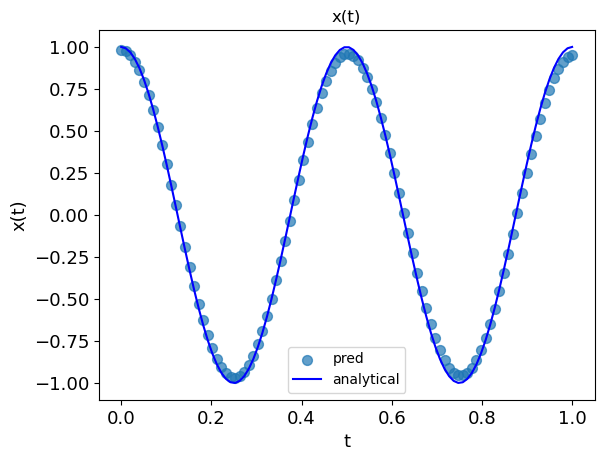

In [24]:
fs=13
plt.scatter(t[0].cpu().detach().numpy(), x_pred[0].cpu().detach().numpy(), label='pred',
            marker='o',
            alpha=.7,
            s=50)
plt.plot(t[0].cpu().detach().numpy(),x_true[0].cpu().detach().numpy(),
         color='blue',
         label='analytical')
plt.xlabel('t', fontsize=fs)
plt.ylabel('x(t)', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend()
plt.title('x(t)')
plt.savefig('x.png')
plt.show()

In [25]:
dxdt = torch.autograd.grad(x_pred, t, torch.ones_like(t), create_graph=True, \
                    retain_graph=True)[0]
dxdt = dxdt.cpu().detach().numpy()[0]

In [26]:
dxdt_true = -x0_true*omega * torch.sin(omega*t)

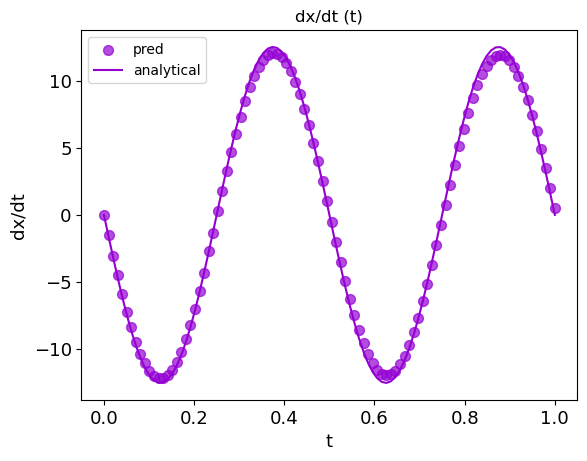

In [27]:
plt.scatter(t[0].cpu().detach().numpy(), dxdt, label='pred',
            marker='o',
            alpha=.7,
            s=50,
            color='darkviolet')
plt.plot(t[0].cpu().detach().numpy(),dxdt_true[0].cpu().detach().numpy(),
         color='darkviolet',
         label='analytical')
plt.xlabel('t', fontsize=fs)
plt.ylabel('dx/dt', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend()
plt.title('dx/dt (t)')
plt.savefig('dxdt.png')
plt.show()

# История

In [28]:
path='loss_pde.csv'
loss_pde=np.genfromtxt(path, delimiter=',')[:, 2]

path='loss_bc.csv'
loss_bc=np.genfromtxt(path, delimiter=',')[:, 2]

path='loss.csv'
total_loss=np.genfromtxt(path, delimiter=',')[:, 2]

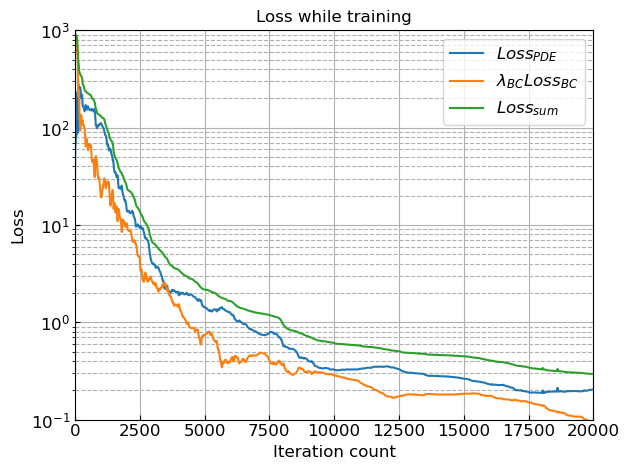

In [29]:
fs = 12

plt.plot(loss_pde, label=r'$Loss_{PDE}$')
plt.plot(1e3*loss_bc, label=r'$\lambda_{BC}Loss_{BC}$')
plt.plot(total_loss, label=r'$Loss_{sum}$')

ax=plt.gca()
ax.set_yscale('log')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle='--')
plt.xlim(0, 2e4)
plt.ylim(1e-1, 1e3)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
ax.tick_params(axis='both',direction='in')

plt.legend(fontsize=fs)
plt.xlabel('Iteration count', fontsize=fs)
plt.ylabel('Loss', fontsize=fs)
plt.title('Loss while training')
plt.tight_layout()
plt.savefig('history_harm.png')
plt.show()